In [29]:
import numpy as np
import librosa
from scipy import signal
from models import *

import soundfile as sf
import pickle

import matplotlib.pyplot as plt

In [49]:
# load the model from checkpoints
generator = GenerativeNetwork()
generator.load_state_dict(torch.load('./checkpoints/vit_sr.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [58]:
# loading spectrogram and normalizing between [0,1]
with open('./data/1877.mus','rb') as fd:
    data = pickle.load(fd)
    
stft = librosa.stft(np.asarray(data), n_fft=4096, win_length=4096, window=signal.windows.hamming(4096))
spectrogram = librosa.amplitude_to_db(abs(stft))

phase = np.angle(stft)
MIN = spectrogram.min()
MAX = spectrogram.max()
spectrogram = (spectrogram-MIN)/(MAX-MIN)


# lb and hb
lb = spectrogram[1:1025,:1024]
hb = spectrogram[1025:,:1024]

lb = torch.tensor(lb.reshape(1,1,1024,1024))
hb = torch.tensor(hb.reshape(1,1,1024,1024))


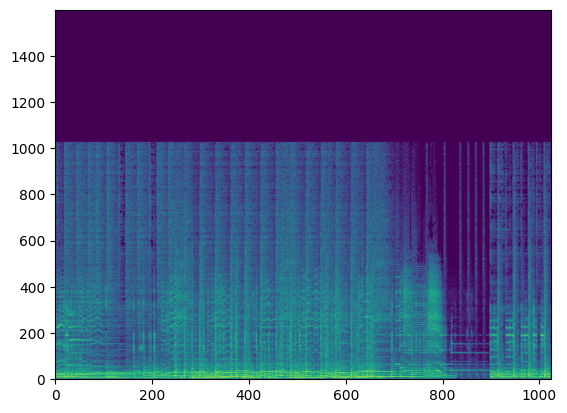

In [73]:
# show low frequencies
plt.imshow(np.concatenate([spectrogram[:1025,:1024],np.zeros((575,1024))]),origin='lower',aspect='auto')

In [61]:
# generate the high frequencies
generated_hb = generator(lb)
gen_hb = generated_hb.detach().numpy().reshape(1024,1024)


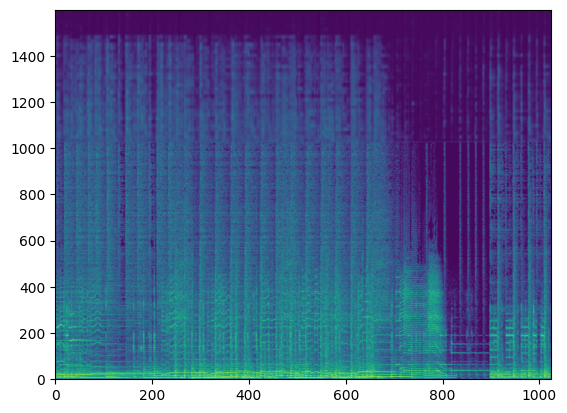

In [68]:
# show reconstructed spectrogram
generated = np.concatenate((lb.cpu().detach().numpy().reshape(1024,1024), gen_hb), axis=0)
generated.shape
plt.imshow(generated[:1600,:], origin='lower', aspect='auto')

In [63]:
# save reconstructed, original and low resolution audio

generated = generated * (MAX-MIN) + MIN
generated = librosa.db_to_amplitude(generated)
generated = generated * np.exp(1j*phase[1:,:1024])
generated = librosa.istft(generated, win_length=4096, window=signal.windows.hamming(4096),n_fft=4096)

sf.write('./out/generated.wav', generated, 44000)


original = spectrogram[:,:1024]
original = original * (MAX-MIN) + MIN
original = librosa.db_to_amplitude(original)
original = original * np.exp(1j*phase[:,:1024])
original = librosa.istft(original, win_length=4096, window=signal.windows.hamming(4096),n_fft=4096)

sf.write('./out/original.wav', original, 44000)


low_res = lb.cpu().detach().numpy().reshape(1024,1024)
low_res = low_res * (MAX-MIN) + MIN
low_res = librosa.db_to_amplitude(low_res)
low_res = low_res * np.exp(1j*phase[1:1025,:1024])
low_res = librosa.istft(low_res, win_length=4096, window=signal.windows.hamming(4096),n_fft=4096)
sf.write('./out/low_res.wav', low_res, 44000)